In [136]:
from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/clarify-adult"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import os
import boto3
from datetime import datetime
import pandas as pd

role = get_execution_role()
s3_client = boto3.client("s3")

In [88]:
%matplotlib inline

In [89]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "adult.data"
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "adult.test"
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data already on disk.
adult.test already on disk.


In [90]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


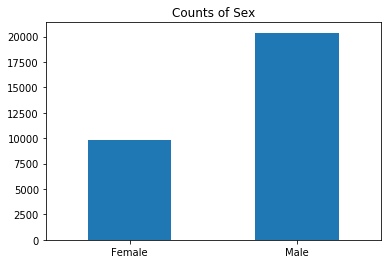

In [91]:
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

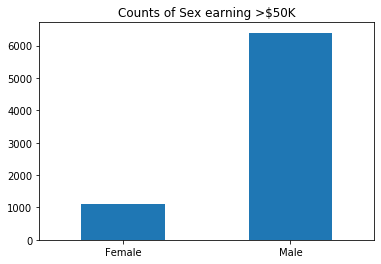

In [93]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

In [94]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [95]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [98]:
from sklearn.model_selection import train_test_split

In [99]:
training_data_divided, _ = train_test_split(training_data, train_size=0.25, stratify=training_data['Target'])
testing_data_divided, _ = train_test_split(testing_data, train_size=0.25, stratify=testing_data['Target'])
test_features_divided = testing_data_divided.drop(["Target"], axis=1)

In [218]:
training_data_divided_no_target = training_data_divided.drop(columns='Target')

In [100]:
training_data_divided.to_csv("train_data_divided.csv", index=False, header=False)
test_features_divided.to_csv("test_features_divided.csv", index=False, header=False)

In [219]:
training_data_divided_no_target.to_csv("train_data_divided_no_target.csv", index=False, header=False)

In [102]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
# test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))
test_uri_divided = S3Uploader.upload("test_features_divided.csv", "s3://{}/{}".format(bucket, prefix))

In [103]:
train_uri_divided = S3Uploader.upload("train_data_divided.csv", "s3://{}/{}".format(bucket, prefix))
test_uri_divided = S3Uploader.upload("test_features_divided.csv", "s3://{}/{}".format(bucket, prefix))

In [220]:
train_uri_divided_no_target = S3Uploader.upload("train_data_divided_no_target.csv", "s3://{}/{}".format(bucket, prefix))

In [104]:
train_input = TrainingInput(train_uri_divided, content_type="csv")

In [105]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-08-03 06:12:10 Starting - Starting the training job...
2022-08-03 06:12:27 Starting - Preparing the instances for training..............
2022-08-03 06:13:44 Downloading - Downloading input data.....
2022-08-03 06:14:15 Training - Downloading the training image..........
2022-08-03 06:15:10 Training - Training image download completed. Training in progress....
2022-08-03 06:15:31 Uploading - Uploading generated training model
2022-08-03 06:15:37 Completed - Training job completed


In [106]:
model_name = "DEMO-clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'DEMO-clarify-model-03-08-2022-06-15-37'

In [107]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

In [113]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri_divided,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [114]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [115]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [116]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

In [117]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-08-03-06-16-56-670
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/train_data_divided.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...............

In [118]:
bias_report_output_path

's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-bias'

In [178]:
test_features_divided.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'],
      dtype='object')

In [179]:
training_data_divided.columns

Index(['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'],
      dtype='object')

In [203]:
shap_config = clarify.SHAPConfig(
    baseline=None,
    num_samples=None,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri_divided,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)
# explainability_data_config = clarify.DataConfig(
#     s3_data_input_path=test_uri_divided,
#     s3_output_path=explainability_output_path,
#     # label='credit_risk', # target column is not present in the test dataset
#     headers=test_features_divided.columns.to_list(),
#     dataset_type="text/csv",
# )

In [205]:
%%time
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-08-04-04-03-30-347
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/train_data_divided.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode':

In [206]:
explainability_output_path

's3://sagemaker-ap-northeast-1-549665692215/sagemaker/clarify-adult/clarify-explainability'

Example number: 111 
with model prediction: False

Feature values -- Label Target                 0
Age                   21
Workclass              2
fnlwgt            199915
Education             15
Education-Num         10
Marital Status         4
Occupation             7
Relationship           3
Ethnic group           4
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per week        40
Country               38
Name: 120, dtype: int64


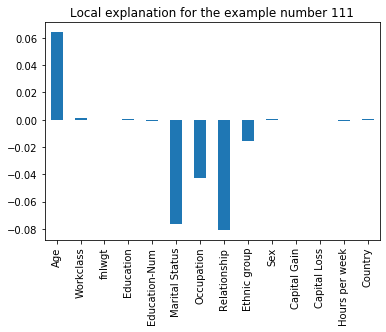

In [207]:
local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

In [209]:
!conda install -c conda-forge shap -y

Solving environment: done

# All requested packages already installed.



In [210]:
import shap

In [126]:
from sagemaker.s3 import S3Downloader

In [137]:
import time

In [211]:
endpoint_name = "adult-pipeline-endpoint-{0}".format(str(int(time.time())))
print(endpoint_name)

xgb.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=endpoint_name
)

adult-pipeline-endpoint-1659597765
-----!

In [140]:
import sagemaker

In [221]:
test_dataset = S3Downloader.read_file(train_uri_divided_no_target)

predictor = sagemaker.predictor.Predictor(
    endpoint_name,
    session,
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

predictions = predictor.predict(test_dataset)

In [222]:
prediction_arr = np.array(predictions).reshape(-1,1)

In [223]:
S3Downloader.download(s3_uri=explainability_output_path + "/explanations_shap", local_path="output")
shap_values_df = pd.read_csv("output/out.csv")

In [225]:
shap_values_df.shape, training_data_divided_no_target.shape

((7540, 14), (7540, 14))

In [226]:
import json

In [227]:
S3Downloader.download(s3_uri=explainability_output_path + "/analysis.json", local_path="output")

with open("output/analysis.json") as json_file:
    data = json.load(json_file)
    base_value = data["explanations"]["kernel_shap"]["label0"]["expected_value"]

print("E(y): ", base_value)

E(y):  0.15619783425548425


In [228]:
from pandas import DataFrame

predictions_df = DataFrame(prediction_arr, columns=["probability_score"])

predictions_df

,probability_score
0,0.004435097798705101
1,0.0005020853714086115
2,0.997680127620697
3,0.7173511385917664
4,0.0022743986919522285
...,...
7535,0.15537331998348236
7536,0.007050753571093082
7537,0.11067968606948853
7538,0.9986116886138916


In [234]:
predictions_df.reset_index(drop=True, inplace=True)
shap_values_df.reset_index(drop=True, inplace=True)
training_data_divided_no_target.reset_index(drop=True, inplace=True)

prediction_shap_df = pd.concat([predictions_df, shap_values_df, training_data_divided_no_target], axis=1)
prediction_shap_df["probability_score"] = pd.to_numeric(
    prediction_shap_df["probability_score"], downcast="float"
)

prediction_shap_df

,probability_score,Age_label0,Workclass_label0,fnlwgt_label0,Education_label0,Education-Num_label0,Marital Status_label0,Occupation_label0,Relationship_label0,Ethnic group_label0,...,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0.004435,-0.008679,0.000627,-0.012944,0.000127,0.000731,-0.052115,-0.021957,-0.039351,-0.002884,...,9,4,0,3,2,0,0,0,40,38
1,0.000502,-0.040837,0.000164,-0.005408,0.002960,0.011738,-0.028896,-0.019754,-0.032887,0.000482,...,10,4,7,3,4,0,0,0,20,38
2,0.997680,0.107862,-0.001064,-0.004261,0.003833,0.172453,0.007129,0.034370,0.057880,0.001401,...,15,2,3,5,4,0,15024,0,47,38
3,0.717351,0.111168,-0.000085,0.172358,0.057261,0.122735,0.018894,0.085636,0.016961,-0.025380,...,10,2,3,0,2,1,0,0,40,38
4,0.002274,-0.058815,0.000806,0.001277,-0.000154,0.000162,-0.048030,0.011455,-0.045303,-0.001022,...,9,4,12,1,4,0,0,0,40,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,0.155373,0.105027,0.000198,0.059515,-0.039308,-0.096652,0.006257,-0.028221,0.006189,0.000089,...,7,2,13,0,4,1,0,0,43,38
7536,0.007051,-0.013455,0.000134,-0.011545,0.001385,0.015579,-0.047142,-0.026894,-0.049212,-0.000943,...,11,4,7,1,4,0,0,0,40,38
7537,0.110680,0.120341,-0.128723,0.001065,-0.011414,0.169823,-0.044108,0.044857,-0.154865,-0.017463,...,13,6,3,4,1,0,0,0,60,36
7538,0.998612,0.161896,0.000276,-0.007527,0.000322,0.118912,0.008439,0.039432,0.006644,-0.000527,...,13,2,3,0,4,1,15024,0,42,38


In [242]:
import matplotlib.pyplot as plt

min_index = prediction_shap_df["probability_score"].idxmax()
print(min_index)
print("mean probability of dataset")
print(prediction_shap_df[["probability_score"]].mean())
print("individual probability")
print(prediction_shap_df.iloc[min_index, 1])
print("sum of shap values")
print(prediction_shap_df.iloc[min_index, 2:22].sum())
print("base value from analysis.json")
print(base_value)

6482
mean probability of dataset
probability_score    0.248989
dtype: float32
individual probability
0.1115725784719791
sum of shap values
362143.7318600385
base value from analysis.json
0.15619783425548425


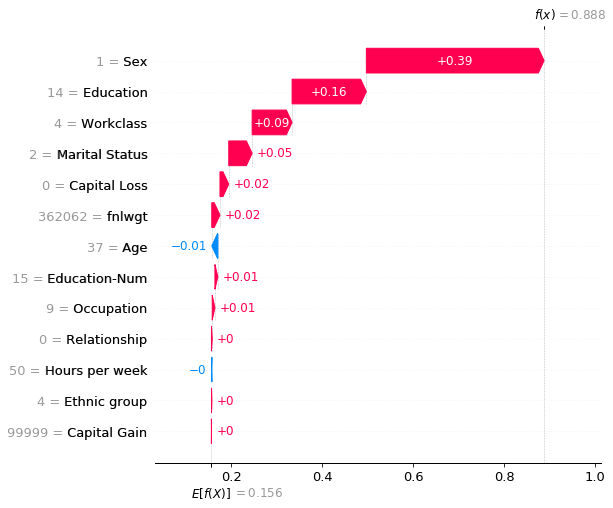

In [244]:
explanation_obj = shap._explanation.Explanation(
    values=prediction_shap_df.iloc[min_index, 2:15].to_numpy(),
    base_values=base_value,
    data=training_data_divided_no_target.iloc[min_index].to_numpy(),
    feature_names=training_data_divided_no_target.columns,
)
shap.plots.waterfall(shap_values=explanation_obj, max_display=20, show=False)